In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import time

In [2]:
print('torch.cuda.is_available:\t',torch.cuda.is_available())
print('torch.cuda.device_count:\t',torch.cuda.device_count())
print('torch.cuda.current_device:\t',torch.cuda.current_device())
print('torch.cuda.device:\t\t',torch.cuda.device(0))
print('torch.cuda.get_device_name:\t',torch.cuda.get_device_name(0))
print()

def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    else:
        print('Running on {}'.format(device))
    return device

device = set_device("gpu")

torch.cuda.is_available:	 True
torch.cuda.device_count:	 1
torch.cuda.current_device:	 0
torch.cuda.device:		 <torch.cuda.device object at 0x7f4df633e800>
torch.cuda.get_device_name:	 Quadro RTX 4000

Cuda installed! Running on GPU 0 Quadro RTX 4000!


In [3]:
# Gauss-Seidel iterative solution of Ax=b
def gauss_seidel(A, b, x0, tolerance=1e-6, max_iterations=10000):
    """
    Solves a linear system of equations using the Gauss-Seidel method.
    
    Parameters
    ----------
    A (numpy.ndarray): Coefficient matrix.
    b (numpy.ndarray): Right-hand side vector.
    x0 (numpy.ndarray): Initial guess for the solution vector.
    tol (float): Tolerance for convergence.
    max_iter (int): Maximum number of iterations.
    
    Returns
    ----------
    x (numpy.ndarray): Solution vector.
    """
    x = x0.clone().detach()
    x_old = x0.clone().detach()
    for k in range(max_iterations):
        #Loop over rows
        for i in range(A.shape[0]):
            x[i] = (b[i] - torch.matmul(A[i,:i], x[:i]) - torch.matmul(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
        #Stop condition 
        error = torch.max(torch.abs(x - x_old))
        if  error < tolerance:
            print(f'The L infinity norm in iteration {k+1} is: {error}') 
            break     
        x_old[:] = x 
    else:
        print(f'***WARNING*** Max number of iteration reached {k+1}, L infinity norm is: {error}')        
    return x

def jacobi(A, b, x0, tolerance=1e-6, max_iterations=50000):
    """
    Solves a linear system of equations using the Jacobi method.
    
    Parameters:
    A (numpy.ndarray): Coefficient matrix.
    b (numpy.ndarray): Right-hand side vector.
    x0 (numpy.ndarray): Initial guess for the solution vector.
    tolerance (float): Tolerance for convergence.
    max_iterations (int): Maximum number of iterations.
    
    Returns:
    x (numpy.ndarray): Solution vector.
    """    
    x_old = x0.clone().detach()
    x = torch.empty_like(x0)
    diagonal = A.diag()
    B = A - torch.diag(diagonal)     
    for k in range(max_iterations): 
        x[:] = (b - torch.matmul(B, x_old)) / diagonal   
        #Stop condition 
        error = torch.max(torch.abs(x - x_old))
        if  error < tolerance:   
            print(f'The L infinity norm in iteration {k+1} is: {error}') 
            break      
        x_old[:] = x
    else:
        print(f'***WARNING*** Max number of iteration reached {k+1}, L infinity norm is: {error}')        
    return x

# solve the linear system Ax=b
def solve_linear(A, b):
        return torch.linalg.solve(A, b)
        #return jacobi(A, b, -b)
        #return gauss_seidel(A, b, -b)
        #return torch.linalg.pinv(A).matmul(b) 

### Advection/Convection Diffusion equation

$
\frac{\displaystyle \partial u}{\displaystyle \partial t} + \mathbf{v} \cdot \nabla u = \alpha\nabla^2 u + f 
$

where

$\nabla \cdot \mathbf{v} = 0$ (incompressible flow)


#### Courant–Friedrichs–Lewy number

$
CFL = \frac{\displaystyle v \Delta t}{\displaystyle \Delta x}  \hspace{0.5cm} \text{one dimentional}\\
CFL \le 1
$

#### Von Neumann stability condition (for explicit)

$
r = \frac{\displaystyle \alpha \Delta t}{\displaystyle (\Delta x)^2} \\
r \le \frac{\displaystyle 1}{\displaystyle 2}
$



In [4]:
# (solve Au=f for each time step) 

class AdvectionDiffusion(nn.Module): 
    """
    Finite difference solution of the Advection/Convection-Diffusion equation (combines parabolic and hyperbolic equations)

    Parameters
    ----------
    alpha: float
        Diffusivity in m*m/s    
    velocity: float
        Velocity in m/s
    dx: float
        Block size in meters
    N: int
        Number of blocks
    initial_condition: list (or numpy array) of floats
        Initial condition (one value per block -> size N)
    boundary_type: list (or numpy array) of str | default ['Dirichlet','Dirichlet']
        Left and right boundary condition type (options: 'Dirichlet', 'Neumann' or 'periodic'), e.g. ['Dirichlet','Neumann'] or ['periodic','periodic']  
    boundary_values: list (or numpy array) of floats | default [0., 0.]    
        Left and right boundary condition values, e.g. [10., -1.]
    time_integration: str | default 'implicit'
        Time integration (options: explict, implicit or Crank-Nicolson), e.g. 'implicit'
    space_discretization: str | default 'upwind'
        Space discretization (options: central or upwind), e.g. 'upwind'
    
    Methods
    -------
    forward(dt, source_term=None)
        Solve the transport equation for one time step of size dt considering the source term

    """  
    def __init__(self, alpha, velocity, dx, N, initial_condition, boundary_type = ['Dirichlet','Dirichlet'], boundary_values=[0, 0], time_integration='implicit', space_discretization='upwind'):   
        super().__init__()
        self.alpha = torch.tensor(alpha, dtype=torch.float32, device=device) 
        self.velocity = torch.tensor(velocity, dtype=torch.float32, device=device) 
        self.dx = torch.tensor(dx, dtype=torch.float32, device=device)  
        self.N = N  # torch.tensor(N, dtype=torch.int32, device=device) -> give error compiled version
        self.u_previous = torch.tensor(initial_condition, dtype=torch.float32, device=device) # For the first time step
        self.boundary_type = boundary_type
        self.boundary_values = torch.tensor(boundary_values, dtype=torch.float32, device=device)
        self.time_integration = time_integration 
        self.space_discretization = space_discretization
        self.A = None
        self.f = None
        #self.timestep_count = 0
        #self.total_time = 0.        
        if space_discretization == 'upwind':
            if velocity>0:
                self.w = torch.tensor(1., dtype=torch.float32, device=device)
            else:
                self.w = torch.tensor(0., dtype=torch.float32, device=device)
        elif space_discretization == 'central':
            self.w = torch.tensor(0.5, dtype=torch.float32, device=device)
        else:
            raise ValueError(f'Space discretization {self.space_discretization} NOT available!')   
    
    # Solve the PDE discretized equation explicitly  
    def solve_explicit(self, dt, source_term):
        
        # Define Courant–Friedrichs–Lewy number
        cfl = self.velocity*dt/self.dx
        
        # Define r
        r = self.alpha*dt/(self.dx*self.dx)
        
        # initialize u and add source term
        u = self.u_previous + dt*source_term
        
        #----------
        # Calculate advection and diffusion terms for elements not in the boundary
        #
        ## Advective term
        for i in range(1,self.N-1): 
            u[i] += -cfl*((self.u_previous[i+1]-self.u_previous[i])*(1-self.w)+(self.u_previous[i]-self.u_previous[i-1])*self.w)  
        ## Diffusive term
        for i in range(1,self.N-1):  
            u[i] += r*(self.u_previous[i-1]-2*self.u_previous[i]+self.u_previous[i+1])              
        
        #----------      
        # Calculate advection and diffusion terms for elements in the boundaries 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            #
            ### Advective term 
            u[0] += -cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.boundary_values[0])*self.w) 
            ### Diffusive term
            u[0] += r*(self.boundary_values[0]-2*self.u_previous[0]+self.u_previous[1])             
        elif self.boundary_type[0] == 'Neumann':
            #
            ### Advective term 
            u[0] += -cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.dx*self.boundary_values[0])*self.w)   
            ### Diffusive term
            u[0] += r*(-self.dx*self.boundary_values[0]-self.u_previous[0]+self.u_previous[1]) 
        elif self.boundary_type[0] == 'periodic':
            #
            ### Advective term 
            u[0] += -cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.u_previous[-1])*self.w)    
            ### Diffusive term
            u[0] += r*(self.u_previous[-1]-2*self.u_previous[0]+self.u_previous[1]) 
        else:
            raise RuntimeError('Left boundary: no condition satisfaed!')    
        #
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            #
            ### Advective term 
            u[-1] += -cfl*((self.boundary_values[-1]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)       
            ### Diffusive term
            u[-1] += r*(self.u_previous[-2]-2*self.u_previous[-1]+self.boundary_values[-1]) 
        elif self.boundary_type[1] == 'Neumann':
            #
            ### Advective term             
            u[-1] += -cfl*((self.dx*self.boundary_values[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)  
            ### Diffusive term
            u[-1] += r*(self.u_previous[-2]-self.u_previous[-1]+self.dx*self.boundary_values[-1])                 
        elif self.boundary_type[1] == 'periodic':
            #
            ### Advective term             
            u[-1] += -cfl*((self.u_previous[0]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)    
            ### Diffusive term
            u[-1] += r*(self.u_previous[-2]-2*self.u_previous[-1]+self.u_previous[0])                 
        else:
            raise RuntimeError('Left boundary: no condition satisfaed!')          
                       
        return u

    # Solve the PDE discretized equation fully implicit  
    def solve_implicit(self, dt, source_term):
        
        # Define Courant–Friedrichs–Lewy number
        cfl = self.velocity*dt/self.dx
        
        # Define r
        r = self.alpha*dt/(self.dx*self.dx)
        
        #----------
        # (Au=f) Calculate matrix A and f 
        #
        ## matrix A
        self.A = torch.diag(torch.ones((self.N,), dtype=torch.float32, device=device), 0)  # Main diagonal (identity)
        #
        ### Advective term 
        a_main_adv = (-cfl*(1-self.w)+cfl*self.w)*torch.ones((self.N,), dtype=torch.float32, device=device)  # Main diagonal values
        a_upper_adv = cfl*(1-self.w)*torch.ones((self.N-1,), dtype=torch.float32, device=device)             # Upper diagonal values
        a_lower_adv = -cfl*self.w*torch.ones((self.N-1,), dtype=torch.float32, device=device)                # Lower diagonal values          
        #
        ### Diffusive term
        a_main_dif = 2*r*torch.ones((self.N,), dtype=torch.float32, device=device)     # Main diagonal values
        a_upper_dif = -r*torch.ones((self.N-1,), dtype=torch.float32, device=device)   # Upper diagonal values
        a_lower_dif = -r*torch.ones((self.N-1,), dtype=torch.float32, device=device)   # Lower diagonal values
        #
        ### fill diagonals
        self.A += torch.diag(a_main_adv + a_main_dif, 0)      # Main diagonal
        self.A += torch.diag(a_upper_adv + a_upper_dif, 1)     # Upper diagonal
        self.A += torch.diag(a_lower_adv + a_lower_dif,-1)     # Lower diagonal   
        #
        ## Source term plus constants f
        self.f = self.u_previous + dt*source_term            
        
        # ----------
        # Calculate boundary conditions 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            #
            ### Advective term             
            self.f[0] += self.boundary_values[0]*cfl*self.w  
            ### Diffusive term      
            self.f[0] += self.boundary_values[0]*r 
        elif self.boundary_type[0] == 'Neumann':
            #
            ### Advective term               
            self.f[0]  += -self.boundary_values[0]*cfl*self.dx*self.w   
            self.A[0,0] += -cfl*self.w
            ### Diffusive term      
            self.f[0]  += -self.boundary_values[0]*r*self.dx   
            self.A[0,0] += -r                
        elif self.boundary_type[0] == 'periodic':
            #
            ### Advective term               
            self.A[0,-1] += -cfl*self.w  
            ### Diffusive term     
            self.A[0,-1] += -r                
        else:
            raise RuntimeError('Left boundary: no condition satisfaed!')
        #
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            #
            ### Advective term              
            self.f[-1] += -self.boundary_values[-1]*cfl*(1-self.w)
            ### Diffusive term     
            self.f[-1] += self.boundary_values[-1]*r
        elif self.boundary_type[1] == 'Neumann':
            #
            ### Advective term              
            self.f[-1] += -self.boundary_values[-1]*cfl*self.dx*(1-self.w)  
            self.A[-1,-1] += cfl*(1-self.w)
            ### Diffusive term     
            self.f[-1] += self.boundary_values[-1]*r*self.dx  
            self.A[-1,-1] += -r            
        elif self.boundary_type[1] == 'periodic':
            #
            ### Advective term              
            self.A[-1,0] += cfl*(1-self.w)
            ### Diffusive term     
            self.A[-1,0] += -r
        else:
            raise RuntimeError('Right boundary: no condition satisfaed!')         
         
        # Calculate u from Au=f
        #u = solve_linear(self.A, self.f)
        u = self.solve_linear()
        
        return u
    
    # Solve the PDE discretized equation using Crank-Nicolson (theta = 0 -> explicit, 1-> implicit)
    def solve_CrankNicolson(self, dt, source_term, theta=0.5):
        
        # Define Courant–Friedrichs–Lewy number
        cfl = self.velocity*dt/self.dx   
        
        # Define r
        r = self.alpha*dt/(self.dx*self.dx)        
        
        #----------
        # (Au=f) Calculate matrix A and f 
        #
        ## matrix A
        self.A = torch.diag(torch.ones((self.N,), dtype=torch.float32, device=device), 0)
        #
        ### Advective term      
        a_main_adv = theta*(-cfl*(1-self.w)+cfl*self.w)*torch.ones((self.N,), dtype=torch.float32, device=device)  # Main diagonal values
        a_upper_adv = theta*cfl*(1-self.w)*torch.ones((self.N-1,), dtype=torch.float32, device=device)             # Upper diagonal values
        a_lower_adv = -theta*cfl*self.w*torch.ones((self.N-1,), dtype=torch.float32, device=device)                # Lower diagonal values           
        #
        ### Diffusive term       
        a_main_dif = theta*2*r*torch.ones((self.N,), dtype=torch.float32, device=device)     # Main diagonal values
        a_upper_dif = -theta*r*torch.ones((self.N-1,), dtype=torch.float32, device=device)   # Upper diagonal values
        a_lower_dif = -theta*r*torch.ones((self.N-1,), dtype=torch.float32, device=device)   # Lower diagonal values        
        #
        ### fill diagonals
        self.A += torch.diag(a_main_adv + a_main_dif, 0)      # Main diagonal
        self.A += torch.diag(a_upper_adv + a_upper_dif, 1)     # Upper diagonal
        self.A += torch.diag(a_lower_adv + a_lower_dif,-1)     # Lower diagonal           
        #
        ## Source term plus constants f
        self.f = self.u_previous + dt*source_term
        ### Advective term    
        for i in range(1,self.N-1):
            self.f[i] += -(1-theta)*cfl*((self.u_previous[i+1]-self.u_previous[i])*(1-self.w)+(self.u_previous[i]-self.u_previous[i-1])*self.w) 
        ### Diffusive term       
        for i in range(1,self.N-1):
            self.f[i] += r*(1-theta)*(self.u_previous[i-1]-2*self.u_previous[i]+self.u_previous[i+1])        
        
        #----------
        # Calculate boundary conditions 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            #
            ### Advective term               
            self.f[0] += -(1-theta)*cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.boundary_values[0])*self.w)
            self.f[0] += theta*self.boundary_values[0]*cfl*self.w 
            ### Diffusive term         
            self.f[0] += (1-theta)*r*(self.boundary_values[0]-2*self.u_previous[0]+self.u_previous[1])
            self.f[0] += theta*r*self.boundary_values[0]            
        elif self.boundary_type[0] == 'Neumann':
            #
            ### Advective term               
            self.f[0] += -(1-theta)*cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.dx*self.boundary_values[0])*self.w)
            self.f[0] += -theta*self.boundary_values[0]*cfl*self.dx*self.w 
            self.A[0,0] += -theta*cfl*self.w
            ### Diffusive term        
            self.f[0] += (1-theta)*r*(-self.dx*self.boundary_values[0]-self.u_previous[0]+self.u_previous[1])
            self.f[0] += -theta*self.dx*r*self.boundary_values[0]     
            self.A[0,0] += -r*theta
        elif self.boundary_type[0] == 'periodic':
            #
            ### Advective term               
            self.f[0] += -(1-theta)*cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.u_previous[-1])*self.w)                
            self.A[0,-1] += -theta*cfl*self.w  
            ### Diffusive term   
            f[0] += (1-theta)*r*(self.u_previous[-1]-2*self.u_previous[0]+self.u_previous[1]) 
            self.A[0,-1] += -theta*r 
        else:
            raise RuntimeError('Left boundary: no condition satisfaed!')
        #
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            #
            ### Advective term              
            self.f[-1] += -(1-theta)*cfl*((self.boundary_values[-1]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)
            self.f[-1] += -theta*self.boundary_values[-1]*cfl*(1-self.w)    
            ### Diffusive term   
            self.f[-1] += (1-theta)*r*(self.u_previous[-2]-2*self.u_previous[-1]+self.boundary_values[-1])
            self.f[-1] += theta*r*self.boundary_values[-1]            
        elif self.boundary_type[1] == 'Neumann':
            #
            ### Advective term              
            self.f[-1] += -(1-theta)*cfl*((self.dx*self.boundary_values[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)
            self.f[-1] += -theta*self.boundary_values[-1]*cfl*self.dx*(1-self.w) 
            self.A[-1,-1] += theta*cfl*(1-self.w) 
            ### Diffusive term   
            self.f[-1] += (1-theta)*r*(self.u_previous[-2]-self.u_previous[-1]+self.dx*self.boundary_values[-1])
            self.f[-1] += self.dx*r*theta*self.boundary_values[-1] 
            self.A[-1,-1] += -r*theta            
        elif self.boundary_type[1] == 'periodic':
            #
            ### Advective term              
            self.f[-1] += -(1-theta)*cfl*((self.u_previous[0]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)                
            self.A[-1,0] += theta*cfl*(1-self.w)   
            ### Diffusive term   
            self.f[-1] += (1-theta)*r*(self.u_previous[-2]-2*self.u_previous[-1]+self.u_previous[0])
            self.A[-1,0] += -theta*r            
        else:
            raise RuntimeError('Right boundary: no condition satisfaed!')
          
        # Calculate u from Au=f
        #u = solve_linear(self.A, self.f)
        u = self.solve_linear()
        
        return u 
    
    # solve the linear system Ax=b
    def solve_linear(self):
            return torch.linalg.solve(self.A, self.f)
            #return jacobi(A, b, -b)
            #return gauss_seidel(A, b, -b)
            #return torch.linalg.pinv(A).matmul(b)     
    
            
    def forward(self, dt, source_term=None):
        """
        Solve the advection/convection-diffusion equation for one time step of size dt considering the source term
        
        
        Parameters
        ----------
        dt: float
            Time step size in seconds
        source_term: list (or numpy array) of floats | default None
            Source term (one value per block -> size N)
        
        Returns
        ----------
        u: numpy array of floats
            resulted field after time step dt (one value per block -> size N)

        """          
        source_term = torch.zeros((self.N,), dtype=torch.float32, device=device) if source_term == None else torch.tensor(source_term, dtype=torch.float32, device=device)
        
        if self.time_integration == 'implicit':
            #self.timestep_count += 1
            #self.total_time += dt
            #print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {self.velocity*dt/self.dx:.2f}, r = {self.alpha*dt/(self.dx*self.dx):.2f}, total time = {self.total_time}s')
           
            u = self.solve_implicit(dt, source_term)
            self.u_previous = u
            
        elif self.time_integration == 'Crank-Nicolson':
            #self.timestep_count += 1
            #self.total_time += dt
            #print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {self.velocity*dt/self.dx:.2f}, r = {self.alpha*dt/(self.dx*self.dx):.2f}, total time = {self.total_time}s')
          
            u = self.solve_CrankNicolson(dt, source_term, theta=0.5)
            self.u_previous = u            
        
        elif self.time_integration == 'explicit':
            #self.timestep_count += 1
            #self.total_time += dt
            #print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {self.velocity*dt/self.dx:.2f}{"(***WARNING cfl>1)" if self.velocity*dt/self.dx > 1.0 else ""}, r = {self.alpha*dt/(self.dx*self.dx):.2f}{"(***WARNING r>=1/2)" if self.alpha*dt/(self.dx*self.dx) >= 0.5 else ""}, total time = {self.total_time}s')
           
            u = self.solve_explicit(dt, source_term)
            self.u_previous = u
            
        else:
            raise RuntimeError(f'Time integration {self.time_integration} NOT available!')
        
        return u

### Solve implicit

In [5]:
advectiondiffusion = AdvectionDiffusion(alpha=0.1,
            velocity = 1.0, 
            dx=0.01,
            N=10000, #110 
            initial_condition =  4000*[0.]+2000*[10.]+4000*[0.], #np.sin(np.linspace(0,2*np.pi,110,endpoint=False)), 
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            #boundary_type = ['Neumann','Neumann'], 
            boundary_type = ['periodic','periodic'], 
            boundary_values = [0, 0],
            time_integration='implicit',
            space_discretization='upwind').to(device)
compiled_advectiondiffusion = torch.compile(advectiondiffusion) #fullgraph=True #mode="max-autotune" #mode="reduce-overhead")

In [6]:
# Initialize u
u=[]
u.append(advectiondiffusion.u_previous.clone().detach().cpu().numpy())  # Initial condition

In [7]:
start = time.time()
with torch.no_grad():
    for _ in range(1):
        compiled_advectiondiffusion(dt=1.0)
    #u.append(compiled_advectiondiffusion(dt=0.5, # seconds
    #                           #source_term=1*[0.]+9*[0.]+1*[0.]
    #                           ).cpu().numpy()
    #        )
time1 = time.time()-start 
print(time1)

3.3369765281677246


20.063505172729492
23.400481700897217


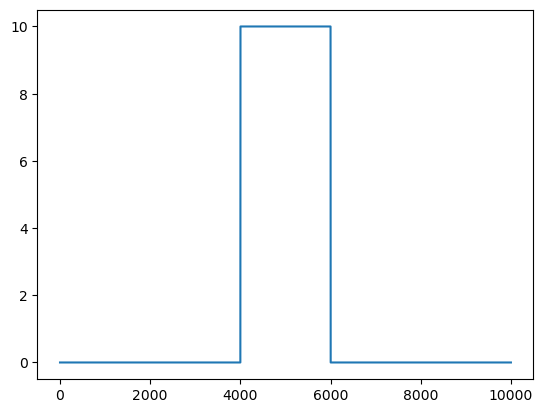

In [8]:
start = time.time()
with torch.no_grad():
    for _ in range(100):
        compiled_advectiondiffusion(dt=1.0)
    #u.append(compiled_advectiondiffusion(dt=0.5, # seconds
    #                           #source_term=1*[0.]+9*[0.]+1*[0.]
    #                           ).cpu().numpy()
    #        )
time2 = time.time()-start 
print(time2)
print(time1+time2)
plt.plot(np.transpose(u));
u_imp = u

A = 
 tensor([[ 2101., -1000.,     0.,  ...,     0.,     0., -1100.],
        [-1100.,  2101., -1000.,  ...,     0.,     0.,     0.],
        [    0., -1100.,  2101.,  ...,     0.,     0.,     0.],
        ...,
        [    0.,     0.,     0.,  ...,  2101., -1000.,     0.],
        [    0.,     0.,     0.,  ..., -1100.,  2101., -1000.],
        [-1000.,     0.,     0.,  ...,     0., -1100.,  2101.]],
       device='cuda:0')

u = 
 [0. 0. 0. ... 0. 0. 0.]

f = 
 tensor([0.0049, 0.0048, 0.0048,  ..., 0.0049, 0.0049, 0.0049], device='cuda:0')



/home/viluiz/anaconda3/envs/numpde/lib/python3.10/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Determinant = inf
Error =  11005.163


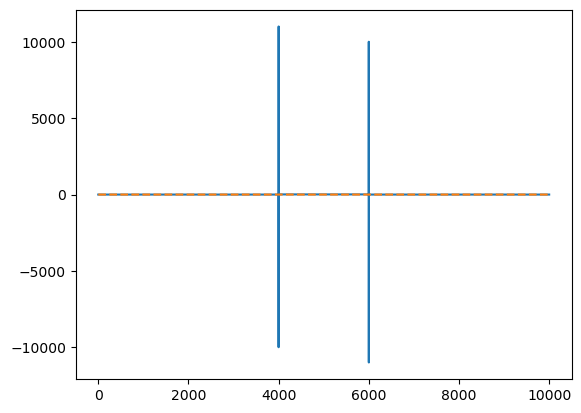

In [9]:
print('A = \n', advectiondiffusion.A)
print()
print('u = \n', u[-1])
print()
print('f = \n', advectiondiffusion.f)
print()
print('Determinant =', np.linalg.det(advectiondiffusion.A.cpu()))
print('Error = ', np.max(abs(np.dot(advectiondiffusion.A.cpu(),u[-1])-advectiondiffusion.f.cpu().numpy())))

plt.plot(np.dot(advectiondiffusion.A.cpu(),u[-1]))
plt.plot(advectiondiffusion.f.cpu().numpy(), '--')

[0. 0. 0. ... 0. 0. 0.]


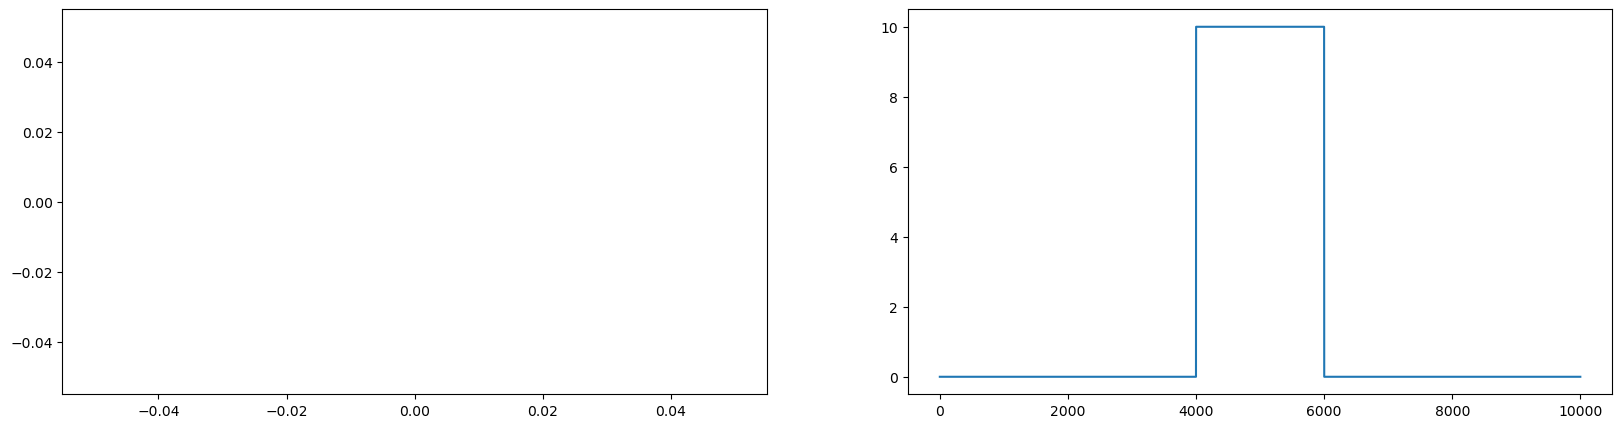

In [10]:
print(u_imp[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_imp)[:,5])
axes[1].plot(u_imp[-1])

### Solve explicit